In [2]:

import soundfile as sf
import csv
import time
import threading
import sounddevice as sd
import numpy as np
from pynput import keyboard
from scipy.io.wavfile import write as wav_write
import os
import librosa


In [3]:
def set_keyboard_layout():
    DATA_DIR = input("Enter the name of the keyboard")
    try:
        os.mkdir(DATA_DIR)
    except FileExistsError:
        print(f"Warning: The directory {DATA_DIR} already exists.")

    return DATA_DIR

# What does this notebook `audio_sampling.ipynb` does ? 
* Register a keyboard (i.e, creating a directory for gathering data on it)
* Recording the necessary data 

## Structure of a keyboard data directory : 
keyboard / 

├── aligned_audio.wav  
├── audio.wav   
├── key_log.csv  
└── numpy_arrays/ 

audio.wav : the recording from the computer
aligned_audio.wav : the aligned recording from a nearby device (ex : iphone)
key_log.csv : the logging of keys pressed with the timestamp of presses / releases
numpy_arrays : folder containing a numpy array for each pair of press/release (one key), compiled in a spectrogram

### The following code is used to record the audio and the keystrokes

*It is not used in the final project, but it is kept here for reference
*The audio recording will go on for 10 seconds. The keystroke recording will be done simultaneously but needs to be stopped manually by pressing ESC (escape)

Head's up : Dont forget to grant accessibility access the editor with which you're running the code below, in particular input monitoring for keystroke recording.


In [3]:
import numpy as np
import csv
import time
import sounddevice as sd
import threading
import scipy.io.wavfile as wav
from pynput import keyboard


start_time_audio = None
stop_recording = False
def data_recording():
    # Parameters for sound recording
    sample_rate = 44100  # Hz
    channels = 1  # Try stereo first
    audio_buffer = []  # Buffer to store audio data

    # File paths

    DATA_DIR = set_keyboard_layout()
    
    audio_file = f'{DATA_DIR}/audio.wav'
    log_file = f'{DATA_DIR}/key_log.csv'

    # Initialize the keystroke log file
    with open(log_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Key', 'Action', 'Timestamp'])

    # Global variables

    def audio_callback(indata, frames, time, status):
        """Callback function for audio streaming"""
        if status:
            print(f"Audio callback status: {status}")
        audio_buffer.append(indata.copy())

    def record_audio():
        global start_time_audio, stop_recording
        print("Recording audio...")
        
        # Set the start time of the recording
        start_time_audio = time.time()
        
        try:
            # Try stereo recording first
            with sd.InputStream(samplerate=sample_rate, channels=channels, callback=audio_callback):
                while not stop_recording:
                    time.sleep(0.01)
        except Exception as e:
            print("Your computer does not support stereo recording. Defaulting to mono.")
            # Try mono recording
            with sd.InputStream(samplerate=sample_rate, channels=1, callback=audio_callback):
                while not stop_recording:
                    time.sleep(0.01)
        
        # When stopped, save the recorded audio
        if audio_buffer:
            audio_data = np.concatenate(audio_buffer, axis=0)
            wav.write(audio_file, sample_rate, audio_data)
            print(f"Audio saved to {audio_file}")
        
        print("Audio recording finished")

        # Keystroke listener function
    def on_press(key,debug=False):
            """"
            helper function to listen for keystrokes and record them on a csv file
            :key : keyboard key object
            """
            if start_time_audio is None:
                return  # Don't log if the audio hasn't started yet

            timestamp = time.time() - start_time_audio  # Calculate relative timestamp
            try:
                key_str = key.char  # Normal keys
            except AttributeError:
                key_str = str(key)  # Special keys like shift, ctrl, etc.

            # Log the key press with relative timestamp
            with open(log_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([key_str, 'Pressed', round(timestamp, 6)])  # Round for cleaner timestamp

            if debug:
                print(f"Key {key_str} Pressed at {timestamp:.6f} seconds")

    def on_release(key,debug=False):
            """"
            helper function to listen for keystrokes and record them on a csv file
            :key : keyboard key object
            """
            if start_time_audio is None:
                return  # Don't log if the audio hasn't started yet

            timestamp = time.time() - start_time_audio  # Calculate relative timestamp
            try:
                key_str = key.char
            except AttributeError:
                key_str = str(key)

            # Log the key release with relative timestamp
            with open(log_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([key_str, 'Released', round(timestamp, 6)])  # Round for cleaner timestamp

            if debug:
                print(f"Key {key_str} Released at {timestamp:.6f} seconds")

            # Stop listener if 'Esc' key is pressed
            if key == keyboard.Key.esc:
                global stop_recording
                stop_recording = True  # Set flag to stop both recordings
                return False

        # Start recording audio in a separate thread
    audio_thread = threading.Thread(target=record_audio)
    audio_thread.start()

        # Start the keyboard listener in the main thread to avoid blocking
    def start_keyboard_listener():
        with keyboard.Listener(on_press=on_press, on_release=on_release) as listener:
            listener.join()

        # Run the keyboard listener in a separate thread
    keyboard_thread = threading.Thread(target=start_keyboard_listener)
    keyboard_thread.start()

        # Wait for both threads to finish, while checking for stop condition
    while not stop_recording:
        time.sleep(0.01)  # Prevent high CPU usage by sleeping briefly

        # Once 'Esc' is pressed, both threads will finish
    audio_thread.join()
    keyboard_thread.join()
    print("Recording process finished.")

data_recording()

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


Recording audio...
Audio saved to dell/audio.wav
Audio recording finished
Recording process finished.


#### This code takes a reference wav (the audio.wav from the computer recording) and another audio (from the nearby device) and aligns it with the keystroke times

In [9]:
from scipy.signal import correlate 
import csv

if "KEYBOARD" not in locals():
    KEYBOARD = set_keyboard_layout()

def align_audios(reference_wav_path, m4a_path, output_path, key_log_path):
    """
    Align and trim an M4A recording to match a reference WAV file using the first keystroke as reference.
    
    Args:
        reference_wav_path (str): Path to the reference WAV file
        m4a_path (str): Path to the M4A file to align
        output_path (str): Path where to save the aligned audio
        key_log_path (str): Path to the key_log.csv file
    """
    print("Loading audio files...")
    
    # Load both audio files
    ref_audio, ref_sr = librosa.load(reference_wav_path)
    m4a_audio, m4a_sr = librosa.load(m4a_path)
    
    # Get the first keystroke timestamp from key_log.csv
    first_key_time = None
    with open(key_log_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        first_row = next(reader)  # Get first row
        first_key_time = float(first_row[2])  # Get timestamp from third column
    
    if first_key_time is None:
        raise ValueError("No keystroke data found in key_log.csv")
    
    print(f"First keystroke at {first_key_time:.2f} seconds")
    
    # Resample if necessary to match sample rates
    if ref_sr != m4a_sr:
        print(f"Resampling M4A from {m4a_sr}Hz to {ref_sr}Hz...")
        m4a_audio = librosa.resample(m4a_audio, orig_sr=m4a_sr, target_sr=ref_sr)
    
    print("Computing cross-correlation to find alignment...")
    
    # Compute cross-correlation to find the best alignment
    correlation = correlate(ref_audio, m4a_audio, mode='full')
    delay = np.argmax(correlation) - (len(m4a_audio) - 1)
    
    # Convert delay to seconds
    delay_seconds = delay / ref_sr
    
    print(f"Found delay of {delay_seconds:.2f} seconds")
    
    # Adjust the delay based on the first keystroke time
    adjusted_delay = delay - int(first_key_time * ref_sr)
    
    if adjusted_delay > 0:
        # Pad the beginning of m4a_audio with zeros
        m4a_audio = np.pad(m4a_audio, (adjusted_delay, 0))
    else:
        # Trim the beginning of m4a_audio
        m4a_audio = m4a_audio[abs(adjusted_delay):]
    
    # Trim to match the length of the reference audio
    if len(m4a_audio) > len(ref_audio):
        m4a_audio = m4a_audio[:len(ref_audio)]
    elif len(m4a_audio) < len(ref_audio):
        m4a_audio = np.pad(m4a_audio, (0, len(ref_audio) - len(m4a_audio)))
    
    print("Saving aligned audio...")

    # Save the aligned audio
    sf.write(output_path, m4a_audio, ref_sr)
    print(f"Aligned audio saved to {output_path}")
    
    return m4a_audio, ref_sr


align_audios(f"{KEYBOARD}/audio.wav", f"{KEYBOARD}/iphone.m4a", f"{KEYBOARD}/aligned_audio.wav", f"{KEYBOARD}/key_log.csv")

# if you simply want to use the computer recording instead of an external one, do : 
def process_without_external_recording():
    os.rename(f"{KEYBOARD}/audio.wav",f"{KEYBOARD}/aligned_audio.wav")

Loading audio files...


/var/folders/9h/65ctz95j25g6fypfgby_mr400000gn/T/ipykernel_46443/3037644956.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  m4a_audio, m4a_sr = librosa.load(m4a_path)


First keystroke at 2.69 seconds
Computing cross-correlation to find alignment...
Found delay of -3.33 seconds
Saving aligned audio...
Aligned audio saved to dell/aligned_iphone.wav


(array([-0.00015045,  0.00170068,  0.00033565, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 22050)

In [ ]:
print(sd.query_devices())  # just for debugging purposes, print the available channels

   0 sof-hda-dsp: - (hw:0,0), ALSA (2 in, 2 out)
   1 sof-hda-dsp: - (hw:0,3), ALSA (0 in, 2 out)
   2 sof-hda-dsp: - (hw:0,4), ALSA (0 in, 2 out)
   3 sof-hda-dsp: - (hw:0,5), ALSA (0 in, 2 out)
   4 sof-hda-dsp: - (hw:0,6), ALSA (4 in, 0 out)
   5 sof-hda-dsp: - (hw:0,7), ALSA (4 in, 0 out)
   6 sof-hda-dsp: - (hw:0,31), ALSA (0 in, 2 out)
   7 sysdefault, ALSA (128 in, 128 out)
   8 lavrate, ALSA (128 in, 128 out)
   9 samplerate, ALSA (128 in, 128 out)
  10 speexrate, ALSA (128 in, 128 out)
  11 pipewire, ALSA (64 in, 64 out)
  12 pulse, ALSA (32 in, 32 out)
  13 speex, ALSA (1 in, 1 out)
  14 upmix, ALSA (8 in, 8 out)
  15 vdownmix, ALSA (6 in, 6 out)
  16 dmix, ALSA (0 in, 2 out)
* 17 default, ALSA (64 in, 64 out)


#### The Key logging data preprocessing : 

* Removes overlapping keys (for example : you pressed "A" and also pressed "B" before releasing "A")
* Removes outlier keys (those that have only being pressed and never released or released but never pressed)

In [8]:
def data_processing():
    """
    Function to preprocess the keystroke data

    In particular, it will : 
    * remove the multiple presses of the same key
    * remove the releases of keys that weren't pressed
    * calculate the average keystroke duration (to optimize the BUFFER parameter)

    Using a stack to keep track of the keys that were pressed and the times at which they were pressed
    """
    DATA_DIR = set_keyboard_layout()

    log_file = f'{DATA_DIR}/key_log.csv'

    averages = []

    total_keystrokes = 0
    # Read keystroke timestamps from CSV
    keystroke_times = []

    with open(log_file, "r") as audio_data_file:
        reader = csv.reader(audio_data_file)
        stack = {}  # Dictionary to store key press times
        key_order = []  # List to track order of key presses
        
        # Skip the header row
        next(reader)
        
        # Count total rows (excluding header)
        rows = list(reader)
        total_keystrokes = len(rows)
        
        # Reset file pointer to after header
        audio_data_file.seek(0)
        next(reader)  # Skip header again
        
        for row in reader:
            key = row[0]
            action = row[1]
            timestamp = float(row[2])

            if action == "Pressed":
                if key in stack:
                    # Ignore multiple presses of the same key
                    continue
                    # then add the time between the last release and this press into the list of in-between intervals
                stack[key] = [key, timestamp]
                key_order.append(key)

            elif action == "Released":
                if key not in stack:
                    # Ignore releases of keys that weren't pressed
                    continue
                
                # Only process the release if it's the most recently pressed key
                if key == key_order[-1]:
                    stack[key].append(timestamp)
                    keystroke_times.append(stack[key])
                    del stack[key]
                    key_order.pop()
                else:
                    # If releasing a key that wasn't the last pressed, skip it
                    continue

    print("Summary of the keystroke data : ")
    print(f"Total valid keystrokes: {len(keystroke_times)}")
    print(f"Total invalid keystrokes: {total_keystrokes//2 - len(keystroke_times)}")  #each key represents a press / release pair so divide by two
    print("Keystroke times:")
    for key, press, release in keystroke_times:
        #print(f"Key: {key}, Press: {press:.3f}, Release: {release:.3f}, Duration: {release-press:.3f}")
        averages.append(release-press)
    
    averages_ = []
    for i in range(len(keystroke_times)-1):
        averages_.append(keystroke_times[i+1][1]-keystroke_times[i][2])
    
    print("Average time between two keys ", sum(averages_)/len(averages_))

    print("Average keystroke duration: ", sum(averages)/len(averages))

    return {"keystroke_times":keystroke_times,"average_duration":averages,"average_interval":averages_}

data_processing()

Summary of the keystroke data : 
Total valid keystrokes: 1096
Total invalid keystrokes: 11
Keystroke times:
Average time between two keys  0.13219127945205475
Average keystroke duration:  0.10812529379562047


[['w', 2.694422, 2.789323],
 ['q', 2.914871, 3.009504],
 ['e', 3.123034, 3.187131],
 ['r', 3.361639, 3.457512],
 ['w', 3.586569, 3.685868],
 ['d', 4.161773, 4.225594],
 ['f', 4.434573, 4.515113],
 ['s', 4.598911, 4.696541],
 ['d', 4.802259, 4.86615],
 ['f', 5.059496, 5.125684],
 ['d', 5.362235, 5.460274],
 ['g', 5.523857, 5.589751],
 ['t', 5.746042, 5.826483],
 ['e', 5.970541, 6.050194],
 ['g', 6.115151, 6.17823],
 ['t', 6.338059, 6.418628],
 ['d', 6.514874, 6.61064],
 ['g', 6.722386, 6.788545],
 ['f', 6.962356, 7.041825],
 ['e', 7.414163, 7.49017],
 ['f', 7.66617, 7.731103],
 ['g', 7.906393, 7.986687],
 ['d', 8.067425, 8.146134],
 ['f', 8.210873, 8.274367],
 ['r', 8.452708, 8.513953],
 ['e', 8.644347, 8.738521],
 ['t', 8.835045, 8.898573],
 ['f', 11.730282, 11.801038],
 ['d', 12.017372, 12.113811],
 ['g', 12.310261, 12.387021],
 ['h', 12.803403, 12.882245],
 ['s', 13.121446, 13.220073],
 ['f', 13.442048, 13.521409],
 ['d', 13.698712, 13.761428],
 ['a', 13.91062, 14.017661],
 ['f', 14.

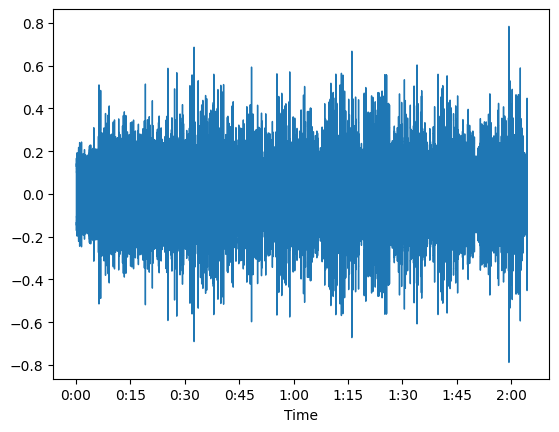

In [10]:
#audio_data, sample_rate = sf.read("lenovo/audio.wav")
#librosa.display.waveshow(audio_data,sr=sample_rate)

###
import librosa 
y, sr = librosa.load("lenovo/audio.wav")
librosa.display.waveshow(y,sr=sr)


## The code that generates individual spectrograms for each keystroke

The following code defines two method to extract the keystrokes and normalize them

1. Using a fixed buffer : split into two, increases the sampling time beyond press /release
> Used by literature in this IEEE article (https://ieeexplore.ieee.org/document/10190721)
2. Audio resampling 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
import csv
from scipy.ndimage import zoom
import os

# Parameters

DATA_DIR = "dell_test" # set_keyboard_layout()
audio_file = f'{DATA_DIR}/aligned_iphone.wav'
log_file = f'{DATA_DIR}/key_log.csv'
AUDIO_FILE = audio_file
KEYSTROKE_CSV = log_file
OUTPUT_DIR = DATA_DIR + "/keystroke_spectrograms"
NUMPY_OUTPUT_DIR = DATA_DIR + "/numpy_arrays"  # New directory for NumPy arrays


# Ensure output directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(NUMPY_OUTPUT_DIR, exist_ok=True)

# Load audio data
sample_rate, audio_data = wav.read(AUDIO_FILE)

# Read keystroke data from CSV
keystroke_times = data_processing()

# Function to create and save the spectrogram and numpy arrays
def create_spectrogram_and_numpy(audio_segment, dataset,extraction_method, key, idx):
    # Generate the spectrogram using scipy

    sample_rate = 44100
    NUMPY_OUTPUT_DIR = dataset + "/numpy_arrays"
    OUTPUT_DIR = dataset + "/keystroke_spectrograms"

    if len(audio_segment.shape) > 1:  # If it's multi-channel
        #print("channel dimension",audio_segment.shape)
        if extraction_method == "mel":
            mel_specs = []
            for channel in range(audio_segment.shape[1]):  # Process each channel
                mel_spec = librosa.feature.melspectrogram(
                    y=audio_segment[:, channel],
                    sr=sample_rate,
                    n_mels=80,
                    n_fft=2048,
                    hop_length=512,
                    window='hann',
                    power=2.0
                )
                # Convert to log scale (dB) and normalize
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
                mel_specs.append(mel_spec_norm)
            
            # Stack the spectrograms along a new axis
            # Shape will be (n_mels, time_steps, channels)
            mel_spect_stacked = np.stack(mel_specs, axis=-1)
            
            # Save the stacked spectrograms as a NumPy array
            numpy_array_path = os.path.join(NUMPY_OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.npy")
            np.save(numpy_array_path, mel_spect_stacked)
            #print(f"Saved 4D NumPy array for '{key}' at {numpy_array_path}")
        elif extraction_method == "FFT":
            spectrograms = []
            target_time_bins = 300
            for channel in range(audio_segment.shape[1]):
                f, t, Sxx = signal.spectrogram(audio_segment[:, channel], sample_rate)
                Sxx_log = 10 * np.log10(Sxx + 1e-10)
                
                time_zoom_factor = target_time_bins / Sxx_log.shape[1]
                Sxx_resampled = zoom(Sxx_log, (1, time_zoom_factor), order=5)
                spectrograms.append(Sxx_resampled)
            
            # Stack spectrograms along a new axis and transpose for PyTorch format
            Sxx_stacked = np.stack(spectrograms, axis=-1)
            Sxx_stacked = np.transpose(Sxx_stacked, (2, 0, 1))
            
            numpy_array_path = os.path.join(NUMPY_OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.npy")
            np.save(numpy_array_path, Sxx_stacked)
            # Create time points for plotting
        else: 
            if extraction_method == "FFT":
                f, t, Sxx = signal.spectrogram(audio_segment, sample_rate)
                Sxx_log = 10 * np.log10(Sxx + 1e-10)
                
                time_zoom_factor = target_time_bins / Sxx_log.shape[1]
                Sxx_resampled = zoom(Sxx_log, (1, time_zoom_factor), order=5)
                
                # Add channel dimension for mono audio
                Sxx_stacked = np.expand_dims(Sxx_resampled, axis=0)
                
                # Create time points for plotting
                numpy_array_path = os.path.join(NUMPY_OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.npy")
                np.save(numpy_array_path, Sxx_stacked)

            elif extraction_method == "mel":

                
                mel_spec = librosa.feature.melspectrogram(
                    y=audio_segment[:, 1],
                    sr=sample_rate,
                    n_mels=80,
                    n_fft=2048,
                    hop_length=512,
                    window='hann',
                    power=2.0
                )
                
                mel_spect_stacked = np.stack(mel_spec, axis=-1)

                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
                mel_specs.append(mel_spec_norm)

                # Stack the spectrograms along a new axis
                # Shape will be (n_mels, time_steps, channels)
                mel_spect_stacked = np.stack(mel_specs, axis=-1)
                
                # Save the stacked spectrograms as a NumPy array
                numpy_array_path = os.path.join(NUMPY_OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.npy")
                np.save(numpy_array_path, mel_spect_stacked)


    #print(f"Saved spectrogram for '{key}' at {spectrogram_path}")
    

def generate_spectrograms(BUFFER,dataset,extraction_method):

    keystroke_times, average_keystroke_duration = data_processing(dataset)

    audio_file = f'{dataset}/aligned_iphone.wav'
    log_file = f'{dataset}/key_log.csv'
    AUDIO_FILE = audio_file
    KEYSTROKE_CSV = log_file
    OUTPUT_DIR = dataset + "/keystroke_spectrograms"
    NUMPY_OUTPUT_DIR = dataset + "/numpy_arrays"  # New directory for NumPy arrays
    sample_rate, audio_data = wav.read(AUDIO_FILE)

    # process each keystroke by sampling each key with press / release times
    for idx, (key, press_time, release_time) in enumerate(keystroke_times):
        # Use exact press and release times without buffer
        start_time = max(0, press_time - BUFFER)  # Ensure we don't go before 0
        end_time = min(len(audio_data) / sample_rate, release_time + BUFFER)  # Ensure we don't go beyond audio length
        
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        # Extract audio segment
        keystroke_audio = audio_data[start_sample:end_sample]
        
        if len(keystroke_audio) == 0:
            print(f"Warning: Empty audio segment for keystroke {idx + 1}")
            continue
            
        create_spectrogram_and_numpy(keystroke_audio,dataset,extraction_method, key, idx)

    print("Processing complete. Spectrograms and NumPy arrays saved.")

    return average_keystroke_duration

Summary of the keystroke data : 
Total valid keystrokes: 67
Total invalid keystrokes: 0
Keystroke times:
Average keystroke duration:  0.08634891044776122
Processing complete. Spectrograms and NumPy arrays saved.


/var/folders/9h/65ctz95j25g6fypfgby_mr400000gn/T/ipykernel_45922/169935986.py:56: UserWarning: nperseg = 256 is greater than input length  = 168, using nperseg = 168
  f, t, Sxx = signal.spectrogram(audio_segment, sample_rate)


In [44]:
# dummy script to generate artificial spectrograms to test the neural network's learning abilities

def generate_artificial_spectrograms(keystroke_times):
    """
    Generate artificial spectrograms with distinct patterns for each key.
    Each key will have a unique vertical line pattern at a specific frequency.
    """
    # Create a mapping of keys to frequencies (using ASCII values to create distinct patterns)
    key_to_freq = {chr(i): i - ord('a') + 1 for i in range(ord('a'), ord('z') + 1)}
    
    # Parameters for the artificial spectrogram
    n_freq_bins = 129
    n_time_bins = 300
    
    # Create output directory if it doesn't exist
    os.makedirs(NUMPY_OUTPUT_DIR, exist_ok=True)

    import random
    
    # Process each keystroke

    for idx, (key, press_time, release_time) in enumerate([[chr(random.randint(97,97+25)), random.randint(0,100), random.randint(0,100)] for _ in range(100)]):
        # Create a blank spectrogram
        spectrogram = np.zeros((1, n_freq_bins, n_time_bins))
        
        # Get the frequency index for this key
        try:
            freq_idx = key_to_freq[key] * 5  # Multiply by 5 to spread out the patterns
        except KeyError:
            print(f"Key '{key}' not found in key_to_freq mapping")
            continue
        
        # Create a vertical line pattern
        # Add a strong signal at the key's frequency
        spectrogram[0, freq_idx:freq_idx+3, :] = 1.0  # No
        
        # Add some noise to make it more realistic
        noise = np.random.normal(0, 0.1, spectrogram.shape)
        spectrogram = np.clip(spectrogram + noise, 0, 1)
        
        # Normalize the spectrogram
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
        
        # Save the artificial spectrogram
        numpy_array_path = os.path.join(NUMPY_OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.npy")
        np.save(numpy_array_path, spectrogram)
        
        # Optionally save a visualization
        #plt.figure(figsize=(10, 4))
        #plt.imshow(spectrogram[0], aspect='auto', cmap='inferno')
       # plt.colorbar(label='Intensity')
        #plt.title(f"Artificial Spectrogram for key '{key}'")
       # plt.xlabel("Time")
        #plt.ylabel("Frequency")
       # plt.savefig(os.path.join(OUTPUT_DIR, f"keystroke_{idx + 1}_{key}.png"))
        #plt.close()
    
    print("Artificial spectrograms generated successfully.")

# Example usage:
# generate_artificial_spectrograms(keystroke_times)
generate_artificial_spectrograms(keystroke_times)

Artificial spectrograms generated successfully.


In [1]:
def coucou():
    """
    Add Docstring
    AND doctest
    """

help(coucou)

Help on function coucou in module __main__:

coucou()
    ruihfurhfurhfur

